# Video Classifier Using CNN and RNN
#!dir

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/train')

label_types = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/train')
print (label_types) 
print(dataset_path) 

C:\Users\youss\AppData\Local\Temp\ipykernel_34220\1698562506.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['no_let', 'stroke', 'yes_let']
['no_let', 'stroke', 'yes_let']


# Preparing Training Data

In [2]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/train' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('D:/!1)year 4/graduation/yolo-trials/labeled videos/train' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())


      tag                                         video_name
0  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
1  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
2  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
3  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
4  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
        tag                                         video_name
76  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
77  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
78  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
79  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
80  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...


In [3]:
df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

# Preparing Test Data

In [4]:
dataset_path = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/test')
print(dataset_path)

room_types = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/test')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('D:/!1)year 4/graduation/yolo-trials/labeled videos/test' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('D:/!1)year 4/graduation/yolo-trials/labeled videos/test' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['no_let', 'stroke', 'yes_let']
Types of activities found:  3
      tag                                         video_name
0  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
1  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
2  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
3  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
4  no_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
        tag                                         video_name
13   stroke  D:/!1)year 4/graduation/yolo-trials/labeled vi...
14   stroke  D:/!1)year 4/graduation/yolo-trials/labeled vi...
15  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
16  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...
17  yes_let  D:/!1)year 4/graduation/yolo-trials/labeled vi...


In [5]:
#!pip install git+https://github.com/tensorflow/docs

In [6]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

# Data preparation

In [8]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(10)

Total videos for training: 81
Total videos for testing: 18


,Unnamed: 0,video_name,tag
6,6,D:/!1)year 4/graduation/yolo-trials/labeled vi...,no_let
7,7,D:/!1)year 4/graduation/yolo-trials/labeled vi...,no_let
52,52,D:/!1)year 4/graduation/yolo-trials/labeled vi...,stroke
48,48,D:/!1)year 4/graduation/yolo-trials/labeled vi...,stroke
5,5,D:/!1)year 4/graduation/yolo-trials/labeled vi...,no_let
17,17,D:/!1)year 4/graduation/yolo-trials/labeled vi...,no_let
67,67,D:/!1)year 4/graduation/yolo-trials/labeled vi...,yes_let
30,30,D:/!1)year 4/graduation/yolo-trials/labeled vi...,stroke
34,34,D:/!1)year 4/graduation/yolo-trials/labeled vi...,stroke
33,33,D:/!1)year 4/graduation/yolo-trials/labeled vi...,stroke


# Feed the videos to a network:


In [9]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
IMG_SIZE = 224


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

   ## Feature Extraction

### InceptionV3

In [10]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
feat_name='inceptionV3'

   ### Shuffle-Net
   

In [ ]:
from keras.applications import ShuffleNet
from keras.layers import Input

def build_feature_extractor():
    feature_extractor = ShuffleNet(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.shufflenet.preprocess_input

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()
feat_name='ShuffleNet'


### Mobile-Net 

In [ ]:
from keras.applications import MobileNet
from keras.layers import Input

def build_feature_extractor():
    feature_extractor = MobileNet(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.mobilenet.preprocess_input

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()
feat_name='MobileNet'

### Efficient-Net

In [ ]:
from keras.applications import EfficientNetB0
from keras.layers import Input

def build_feature_extractor():
    feature_extractor = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()
feat_name='EfficientNet'

### ALL IN ONE

In [ ]:
from keras.layers import Input
from keras.applications import InceptionV3, ShuffleNet, MobileNet, EfficientNetB0

def build_feature_extractor(model_name):
    if model_name == "InceptionV3":
        base_model = InceptionV3(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        preprocess_input = keras.applications.inception_v3.preprocess_input
    elif model_name == "ShuffleNet":
        base_model = ShuffleNet(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        preprocess_input = keras.applications.shufflenet.preprocess_input
    elif model_name == "MobileNet":
        base_model = MobileNet(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        preprocess_input = keras.applications.mobilenet.preprocess_input
    elif model_name == "EfficientNet":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
        preprocess_input = keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError("Unsupported model name")

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = base_model(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

# Example usage:
#////// model_name = "EfficientNet"
feature_extractor = build_feature_extractor(model_name)


### Label Encoding
StringLookup layer encode the class labels as integers.

In [11]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

['no_let', 'stroke', 'yes_let']



array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int64)

Finally, we can put all the pieces together to create our data processing utility.

In [12]:
#print(train_data[0].shape)
#train_data[0]

In [13]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048 ######### change back to 2048 for inception model , 1024 for mobile net , 1280 for efficient net

In [14]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values
    
    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATURES = 2048. We have defined this above under hyper parameters
#MAX_SEQ_LENGTH = 30 (CHANGED) ###############################################

1/1 [==============================] - 0s 68ms/step
Frame features in train set: (81, 20, 2048)
Frame masks in train set: (81, 20)
train_labels in train set: (81, 1)
test_labels in train set: (18, 1)


# The sequence model
Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

Epoch 1/30
1/3 [=========>....................] - ETA: 20s - loss: 1.1856 - accuracy: 0.2812
Epoch 1: val_loss improved from inf to 1.10586, saving model to ./tmp\video_classifier
3/3 [==============================] - 14s 2s/step - loss: 1.1750 - accuracy: 0.3457 - val_loss: 1.1059 - val_accuracy: 0.1667
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 1.1735 - accuracy: 0.2500
Epoch 2: val_loss improved from 1.10586 to 1.10546, saving model to ./tmp\video_classifier
3/3 [==============================] - 0s 65ms/step - loss: 1.1333 - accuracy: 0.3086 - val_loss: 1.1055 - val_accuracy: 0.3889
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 1.2143 - accuracy: 0.2500
Epoch 3: val_loss improved from 1.10546 to 1.09919, saving model to ./tmp\video_classifier
3/3 [==============================] - 0s 53ms/step - loss: 1.1645 - accuracy: 0.3086 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 1.187

c:\Users\youss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\youss\AppData\Local\Temp\ipykernel_34220\2874862651.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'True Negatives: {TN[i]}')
C:\Users\youss\AppData\Local\Temp\ipykernel_34220\2874862651.py:193: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

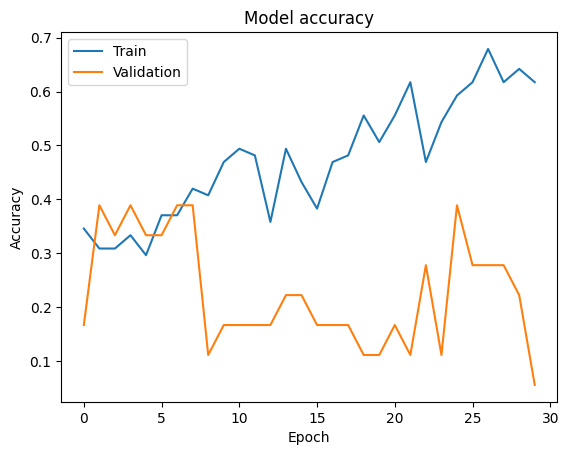

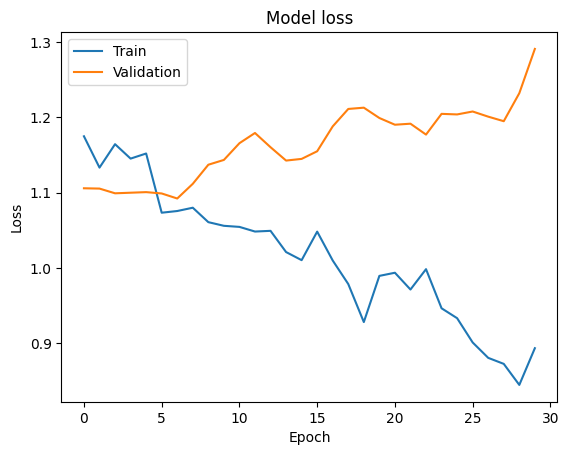

In [33]:
# Utility for our sequence model.
sequence_name=None

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

sequence_name='RNN'
'''
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Replace GRU with LSTM
    x = keras.layers.LSTM(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.LSTM(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    lstm_model = keras.Model([frame_features_input, mask_input], output)

    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return lstm_model

sequence_name='LSTM'    
'''

EPOCHS = 30
# Utility for running experiments.
'''
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model
'''
'''
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    y_true = test_labels
    y_pred = np.argmax(seq_model.predict([test_data[0], test_data[1]]), axis=1)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Macro F1 score: {f1}')

    # Calculate confusion matrix
    print("test labels =", test_labels)
    print("train labels =", train_labels)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', conf_matrix)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='macro')
    print(f'Macro Precision: {precision}')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Macro Recall: {recall*100 }%')

    return history, seq_model
'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    
    start_training_time = time.time()  # Record start time for training
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]], test_labels),
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )
    end_training_time = time.time()  # Record end time for training

    seq_model.load_weights(filepath)
    y_true = test_labels
    
    start_testing_time = time.time()  # Record start time for testing
    y_pred = np.argmax(seq_model.predict([test_data[0], test_data[1]]), axis=1)
    end_testing_time = time.time()  # Record end time for testing
    
    print("Classifier Name :", sequence_name)
    print('The feature extractor used is:', feat_name)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Macro F1 score: {f1}')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_labels = label_processor.get_vocabulary()
    conf_matrix = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print('Confusion Matrix:\n', conf_matrix)

    # Extract TP, TN, FP, FN for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    for i, label in enumerate(class_labels):
        print(f'Class: {label}')
        print(f'True Positives: {TP[i]}')
        print(f'True Negatives: {TN[i]}')
        print(f'False Positives: {FP[i]}')
        print(f'False Negatives: {FN[i]}')

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2%}')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='macro')
    print(f'Macro Precision: {precision}')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Macro Recall: {recall}')

    # Print training and testing times
    training_time = end_training_time - start_training_time
    testing_time = end_testing_time - start_testing_time
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plot_training_history(history)

    return history, seq_model

_, sequence_model = run_experiment()


# Inference

In [16]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

#test_video='D:/!1)year 4/graduation/yolo-trials/labeled videos/test/yes_let/yes_let(1).mp4'
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)
print("The original decision is :",os.path.basename(test_video))
print("The Feature extractor used is :",feat_name)
print("The sequence model used is :",sequence_name)

Test video path: D:/!1)year 4/graduation/yolo-trials/labeled videos/test/stroke/stroke.mp4
1/1 [==============================] - 0s 40ms/step
  no_let: 36.53%
  yes_let: 33.68%
  stroke: 29.80%
The original decision is : stroke.mp4
The Feature extractor used is : inceptionV3
The sequence model used is : RNN


In [17]:

'''
from IPython.display import HTML

HTML("""
    <video alt="test" width="520" height="440" controls>
        <source src="D:/!1)year 4/graduation/yolo-trials/labeled videos/test/yes_let/yes_let(1).mp4" style="height:300px;width:300px">
    </video>
""")
'''


'\nfrom IPython.display import HTML\n\nHTML("""\n    <video alt="test" width="520" height="440" controls>\n        <source src="D:/!1)year 4/graduation/yolo-trials/labeled videos/test/yes_let/yes_let(1).mp4" style="height:300px;width:300px">\n    </video>\n""")\n'